# Subgroup Robustness Grows on Trees (Experiments)
Here are some initial experiments corroborating the empirical observations from *Subgroup Robustness Grows on Trees*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSIncome

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# ACS Income Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual has a income over $50,000 after filtering the survey to include only individuals above the age of 16, who reported
usual working hours of at least 1 hour per week in the previous year, and an income of at least $100.
The full dataset has $n = 1,664,500$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 190, 187$ examples total.

## Preprocess and Clean ACS Income
The ACS Income dataset (California, 2016) is a binary classification task with $d=10$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [2]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
print("ACS Income Features: {}".format(ACSIncome.features))
print("ACS Income Shape {}".format(features.shape))

ACS Income Features: ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']
ACS Income Shape (190187, 10)


In [3]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [4]:
to_one_hot = set(['COW', 'MAR', 'OCCP', 'POBP', 'RELP', 'RAC1P'])
to_leave_alone = set(ACSIncome.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
ct = ColumnTransformer(steps)
features_t = ct.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (190187, 733)


In [5]:
# Train-test split
splits = train_test_split(*tuple([features_t, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	152149	38038
1 (R1)	94588	23624
2 (R2)	6965	1691
3 (R3)	938	222
4 (R6)	24273	6067
5 (R7)	546	153
6 (R8)	18615	4670
7 (R9)	5887	1523
8 (S1)	80916	20209
9 (S2)	71233	17829
10 (A1)	143354	35822
11 (A2)	8795	2216


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.37969924812030076
P(Y=1 | group 1) = 0.41500169319336266
P(Y=1 | group 2) = 0.3116499112950917
P(Y=1 | group 3) = 0.23423423423423423
P(Y=1 | group 4) = 0.45953519037415524
P(Y=1 | group 5) = 0.1830065359477124
P(Y=1 | group 6) = 0.15331905781584582
P(Y=1 | group 7) = 0.33223900196979644
P(Y=1 | group 8) = 0.42817556534217427
P(Y=1 | group 9) = 0.3247518088507488
P(Y=1 | group 10) = 0.3703310814583217
P(Y=1 | group 11) = 0.5311371841155235


## Fit and Evaluate Models (ACS Employment)
We fit and evaluate our models here. There are four classes of models we'd like to evaluate:
1. *Tree-based models.* Includes Random Forests and Gradient-Boosted Trees.
2. *Baseline models.* Includes SVM, Logistic Regression, and a 2-layer neural net.
3. *Prepend.* Use all of the above as base classes.
4. *DRO.* Includes Group DRO and $\chi^2$-DRO, each with the base hypothesis class of 2-layer neural nets.

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from joblib import Parallel, delayed

In [9]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        if transformer:
            H_train[g] = models[g].predict(transformer.transform(X_train))
            H_test[g] = models[g].predict(transformer.transform(X_test))
        else:
            H_train[g] = models[g].predict(X_train)
            H_test[g] = models[g].predict(X_test)
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, model_name, 
                   param_name, param_val,
                   params={}, verbose=False):
    if verbose:
        print("{0} ({1}={2})".format(model_name, param_name, param_val))
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        if transformer:
            models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
            yhats[g] = models[g].predict(transformer.transform(X_test))
        else:
            models[g].fit(X_train[group_train[g]], y_train[group_train[g]])
            yhats[g] = models[g].predict(X_test)
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, None, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err


### Tree-Based Models
We train the following models:

1. *Random Forest.*
2. *Random Forest, per group.*
3. *Prepend (Random Forest).*
4. *Gradient-Boosted Trees.*
5. *Gradient-Boosted Trees, per group.*
6. *Prepend (Gradient Boosted Trees).*

using a hyperparameter sweep of: $\mathrm{num\_estimators} = \{ 64, 128, 256, 512, 1024 \}.$

In [10]:
all_rfs = {}            # indexed by num_estimator
rf_prepend = {}         # indexed by num_estimator
all_gbs = {}            # indexed by num_estimator
gb_prepend = {}         # indexed by num_estimator

In [11]:
# Train and evaluate: Random Forests
# For parallelizing the hyperparameter sweep
# num_estimator_params = [1, 64, 128, 256, 512, 1024]
num_estimator_params = [64, 128, 256]
param_dicts = [{'n_estimators' : n_estimators, 'random_state' : 0} for n_estimators in num_estimator_params]
iterate_params = zip(num_estimator_params, param_dicts)

parallel = Parallel(n_jobs=3, verbose=25)
results = parallel(
    delayed(train_and_eval)(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   None, num_groups, 
                   RandomForestClassifier, "Random Forests", 
                   "n_estimators", param_val=n_estimators,
                   params=params, verbose=False
    )
    for n_estimators, params in iterate_params
)

# Populate dictionaries with results
for i, result in enumerate(results):
    all_rfs[num_estimator_params[i]] = {}
    all_rfs[num_estimator_params[i]]['models'] = result[0]
    all_rfs[num_estimator_params[i]]['yhats'] = result[1]
    all_rfs[num_estimator_params[i]]['test_err'] = result[2]
    all_rfs[num_estimator_params[i]]['erm_test_err'] = result[3]

    rf_prepend[num_estimator_params[i]] = {}
    rf_prepend[num_estimator_params[i]]['model'] = result[4]
    rf_prepend[num_estimator_params[i]]['F_test_err'] = result[5]

del results
del parallel

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 12.4min finished


In [13]:
# Train and evaluate: Gradient-Boosted Trees
# IMPORTANT: need to re-initialize the iterate_params because zip is an iterable
#num_estimator_params = [1, 64, 128, 256, 512, 1024]
num_estimator_params = [64, 128, 256]
param_dicts = [{'n_estimators' : n_estimators, 'random_state' : 0} for n_estimators in num_estimator_params]
iterate_params = zip(num_estimator_params, param_dicts)

with Parallel(n_jobs=3, verbose=15) as parallel:
    results = parallel(
        delayed(train_and_eval)(X_train, group_train, 
                    X_test, group_test, 
                    y_train, y_test, 
                    None, num_groups, 
                    GradientBoostingClassifier, "Gradient-Boosted Trees", 
                    "n_estimators", param_val=n_estimators,
                    params=params, verbose=False
        )
        for n_estimators, params in iterate_params
    )

    # Populate dictionaries with results
    for i, result in enumerate(results):
        all_gbs[num_estimator_params[i]] = {}
        all_gbs[num_estimator_params[i]]['models'] = result[0]
        all_gbs[num_estimator_params[i]]['yhats'] = result[1]
        all_gbs[num_estimator_params[i]]['test_err'] = result[2]
        all_gbs[num_estimator_params[i]]['erm_test_err'] = result[3]

        gb_prepend[num_estimator_params[i]] = {}
        gb_prepend[num_estimator_params[i]]['model'] = result[4]
        gb_prepend[num_estimator_params[i]]['F_test_err'] = result[5]

    del results
    del parallel

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed: 14.6min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 27.5min remaining:    0.0s


KeyboardInterrupt: 

### Baseline Models
We train and evaluate with three different baseline models. This gives nine different varieties of models.

1. *Logistic Regression.*
2. *Logistic Regression, per group.*
3. *Prepend (Logistic Regression).*
4. *SVM.*
5. *SVM, per group.*
6. *Prepend (SVM).*
7. *2-layer MLP (varying hidden units).*
8. *2-layer MLP, per group.*
9. *Prepend (2-layer MLP).*

The hyperparameter sweep for the MLP is: $\mathrm{hidden\_units} := \{64, 128, 256\}.$

In [14]:
logreg = {}      
logreg_prepend = {}
svm = {}
svm_prepend = {}
all_mlps = {}
mlps_prepend = {}

In [15]:
# Train and evaluate: Logistic Regression
logreg_params = {
    "cv": 3,
    "max_iter": 500
}
result = train_and_eval(X_train, group_train,
                        X_test, group_test,
                        y_train, y_test,
                        None, num_groups,
                        LogisticRegressionCV, "Logistic Regression",
                        param_name="CV", param_val=3, params=logreg_params,
                        verbose=True)

logreg['models'] = result[0]
logreg['yhats'] = result[1]
logreg['test_err'] = result[2]
logreg['erm_test_err'] = result[3]
logreg_prepend['model'] = result[4]
logreg_prepend['F_test_err'] = result[5]

Logistic Regression (CV=3)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 0 (ALL): 0.1769809138230191 (+/-0.002767415256236685; n=38038)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 1 (R1): 0.18633592956315612 (+/-0.003582689347799166; n=23624)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


group 2 (R2): 0.20283855706682435 (+/-0.013829025981269413; n=1691)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


group 3 (R3): 0.24774774774774774 (+/-0.04097558064643266; n=222)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 4 (R6): 0.18872589418163838 (+/-0.007104402418390026; n=6067)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 6 (R8): 0.1252676659528908 (+/-0.006850363869721284; n=4670)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 7 (R9): 0.175311884438608 (+/-0.013778933153021899; n=1523)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

group 8 (S1): 0.18373002127764856 (+/-0.003852561325313195; n=20209)


/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

KeyboardInterrupt: 

In [14]:
# Train and evaluate: SVM
# Train and evaluate: Logistic Regression
svm_params = {}
result = train_and_eval(X_train, group_train,
                        X_test, group_test,
                        y_train, y_test,
                        None, num_groups,
                        SVC, "SVM",
                        param_name="noparams", param_val="noparams", params=svm_params,
                        verbose=True)

svm['models'] = result[0]
svm['yhats'] = result[1]
svm['test_err'] = result[2]
svm['erm_test_err'] = result[3]
svm_prepend['model'] = result[4]
svm_prepend['F_test_err'] = result[5]

SVM (noparams=noparams)
group 0 (ALL): 0.16263128800442234 (+/-0.005487456970751335; n=9045)
group 1 (W,M): 0.2106331918035813 (+/-0.007834989430363214; n=5417)
group 2 (W,F): 0.090562843842573 (+/-0.008349193182249071; n=2363)
group 3 (nW,M): 0.17341040462427745 (+/-0.020353752703390026; n=692)
group 4 (nW,F): 0.06631762652705062 (+/-0.014701165075800321; n=573)
PREPEND group 0 (ALL): 0.16263128800442234 (+/-0.005487456970751335; n=9045)
PREPEND group 1 (W,M): 0.2074949233893299 (+/-0.0077918457103755565; n=5417)
PREPEND group 2 (W,F): 0.08463817181548879 (+/-0.008097718454620994; n=2363)
PREPEND group 3 (nW,M): 0.16329479768786126 (+/-0.01987166969487615; n=692)
PREPEND group 4 (nW,F): 0.059336823734729496 (+/-0.013957797908572664; n=573)


In [15]:
# Train and evaluate: MLP
# For parallelizing the hyperparameter sweep over MLP hidden units
import warnings
warnings.filterwarnings('ignore') 

#hidden_layer_params = [[64, 64], [128, 128], [256, 256]]
#hidden_layer_param_names = [64, 128, 256]
hidden_layer_params = [[64, 64], [128, 128]]
hidden_layer_param_names = [64, 128]
param_dicts = [{'hidden_layer_sizes' : hidden_layer, 'batch_size' : 128} for hidden_layer in hidden_layer_params]
iterate_params = zip(hidden_layer_param_names, param_dicts)

parallel_mvp = Parallel(n_jobs=2, verbose=15)
results = parallel_mvp(
    delayed(train_and_eval)(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   None, num_groups, 
                   MLPClassifier, "2-Layer MLP", 
                   "hidden_units", param_val=hidden_units,
                   params=params, verbose=False
    )
    for hidden_units, params in iterate_params
)

# Populate dictionaries with results
for i, result in enumerate(results):
    all_mlps[hidden_layer_param_names[i]] = {}
    all_mlps[hidden_layer_param_names[i]]['models'] = result[0]
    all_mlps[hidden_layer_param_names[i]]['yhats'] = result[1]
    all_mlps[hidden_layer_param_names[i]]['test_err'] = result[2]
    all_mlps[hidden_layer_param_names[i]]['erm_test_err'] = result[3]

    mlps_prepend[hidden_layer_param_names[i]] = {}
    mlps_prepend[hidden_layer_param_names[i]]['model'] = result[4]
    mlps_prepend[hidden_layer_param_names[i]]['F_test_err'] = result[5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/essdee/miniconda3/envs/tree_robust/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Sto

## Plot Results (Adult)

### Find Worst-Group Errors
For each model, we find the worst-group errors for simplifying each of the following plots.

In [16]:
# find the worst-group errors for each tree-based model
tree_params = [1, 64, 128, 256, 512, 1024]
for n_trees in tree_params:
    max_err_rf = -np.inf
    max_err_rf_prepend = -np.inf
    max_err_gb = -np.inf
    max_err_gb_prepend = -np.inf

    argmax_err_rf = None
    argmax_err_rf_prepend = None
    argmax_err_gb = None
    argmax_err_gb_prepend = None

    for g in range(1, num_groups):  # skip the ALL group
        if all_rfs[n_trees]['erm_test_err'][g] > max_err_rf:
            max_err_rf = all_rfs[n_trees]['erm_test_err'][g]
            argmax_err_rf = g
        if rf_prepend[n_trees]['F_test_err'][g] > max_err_rf_prepend:
            max_err_rf_prepend = rf_prepend[n_trees]['F_test_err'][g]
            argmax_err_rf_prepend = g
        if all_gbs[n_trees]['erm_test_err'][g] > max_err_gb:
            max_err_gb = all_gbs[n_trees]['erm_test_err'][g]
            argmax_err_gb = g
        if gb_prepend[n_trees]['F_test_err'][g] > max_err_gb_prepend:
            max_err_gb_prepend = gb_prepend[n_trees]['F_test_err'][g]
            argmax_err_gb_prepend = g
        
    all_rfs[n_trees]['worst_gp_err'] = (max_err_rf, argmax_err_rf)
    rf_prepend[n_trees]['worst_gp_err'] = (max_err_rf_prepend, argmax_err_rf_prepend)
    all_gbs[n_trees]['worst_gp_err'] = (max_err_gb, argmax_err_gb)
    gb_prepend[n_trees]['worst_gp_err'] = (max_err_gb_prepend, argmax_err_gb_prepend)

In [17]:
# find the worst-group errors for each baseline model
max_err_logreg = -np.inf
max_err_logreg_prepend = -np.inf
max_err_svm = -np.inf
max_err_svm_prepend = -np.inf

argmax_err_logreg = None
argmax_err_logreg_prepend = None
argmax_err_svm = None
argmax_err_svm_prepend = None

for g in range(1, num_groups):  # skip the ALL group
    if logreg['erm_test_err'][g] > max_err_logreg:
        max_err_logreg = logreg['erm_test_err'][g]
        argmax_err_logreg = g
    if logreg_prepend['F_test_err'][g] > max_err_logreg_prepend:
        max_err_logreg_prepend = logreg_prepend['F_test_err'][g]
        argmax_err_logreg_prepend = g
    if svm['erm_test_err'][g] > max_err_svm:
        max_err_svm = svm['erm_test_err'][g]
        argmax_err_svm = g
    if svm_prepend['F_test_err'][g] > max_err_svm_prepend:
        max_err_svm_prepend = svm_prepend['F_test_err'][g]
        argmax_err_svm_prepend = g

logreg['worst_gp_err'] = (max_err_logreg, argmax_err_logreg)
logreg_prepend['worst_gp_err'] = (max_err_logreg_prepend, argmax_err_logreg_prepend)
svm['worst_gp_err'] = (max_err_svm, argmax_err_svm)
svm_prepend['worst_gp_err'] = (max_err_svm_prepend, argmax_err_svm_prepend)

In [18]:
# find the worst-group errors for each MLP model
hidden_unit_params = [64, 128, 256]
for hidden_units in hidden_unit_params:
    max_err_mlp = -np.inf
    max_err_mlp_prepend = -np.inf

    argmax_err_mlp = None
    argmax_err_mlp_prepend = None

    for g in range(1, num_groups):  # skip the ALL group
        if all_mlps[hidden_units]['erm_test_err'][g] > max_err_mlp:
            max_err_mlp = all_mlps[hidden_units]['erm_test_err'][g]
            argmax_err_mlp = g
        if mlps_prepend[hidden_units]['F_test_err'][g] > max_err_mlp_prepend:
            max_err_mlp_prepend = mlps_prepend[hidden_units]['F_test_err'][g]
            argmax_err_mlp_prepend = g
        
    all_mlps[hidden_units]['worst_gp_err'] = (max_err_mlp, argmax_err_mlp)
    mlps_prepend[hidden_units]['worst_gp_err'] = (max_err_mlp_prepend, argmax_err_mlp_prepend)

### Plot 1: Overall Comparison
For each group, we compare the following models:

1. **RF-Best.** The Random Forest model (instance of `n_estimators`) with the lowest worst-group risk.
2. **GBM-Best.** The Gradient-Boosted Trees model (instance of `n_estimators`) with the lowest worst-group risk.
3. **Baseline-Best.** The baseline model (out of Logistic Regression and SVM) with the lowest worst-group risk.
4. **Baseline-Best-Group.** Using the baseline model from (3), the per-group risks.
5. **MLP-Best.** The MLP model (instance of `hidden_layer_size`) with the lowest worst-group risk.
6. **MLP-Best-Group.** Using the baseline model from (5), the per-groups risks.
7. **Prepend-Baseline-Best.** Out of all the baseline Prepend models, the one with the lowest worst-group risk.
8. **Prepend-Tree-Best.** Out of all the tree-based Prepend models, the one with the lowest worst-group risk.
9. **Prepend-MLP-Best.** Out of all the MLP Prepend models, the one with the lowest worst-group risk.

In [19]:
# Find the "bests" for each range of models
rf_best = all_rfs[tree_params[np.argmin([all_rfs[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
gb_best = all_gbs[tree_params[np.argmin([all_gbs[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
mlp_best = all_mlps[hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]]
rf_prepend_best = rf_prepend[tree_params[np.argmin([rf_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
print("Best RF Prepend: {}".format(tree_params[np.argmin([rf_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]))
gb_prepend_best = gb_prepend[tree_params[np.argmin([gb_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]]
print("Best GB Prepend: {}".format(tree_params[np.argmin([gb_prepend[n_trees]['worst_gp_err'][0] for n_trees in tree_params])]))
mlp_prepend_best = mlps_prepend[hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]]
print("Best MLP Prepend: {}".format(hidden_unit_params[np.argmin([all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params])]))

Best RF Prepend: 512
Best GB Prepend: 512
Best MLP Prepend: 64


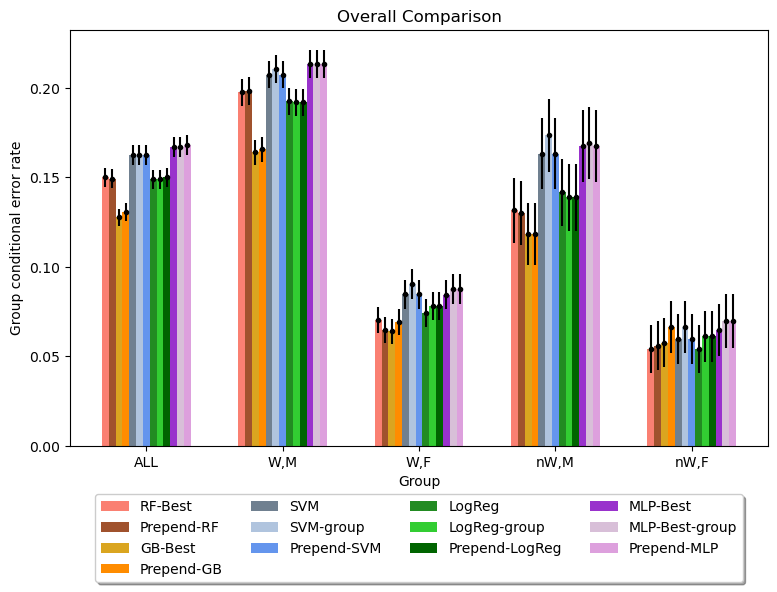

In [20]:
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.05

plot_rects1 = ax.bar(plot_x - 6.0*bar_width, [rf_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-Best', color="salmon")
plot_rects2 = ax.bar(plot_x - 5.0*bar_width, [rf_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-RF', color="sienna")
plot_rects3 = ax.bar(plot_x - 4.0*bar_width, [gb_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-Best', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 3.0*bar_width, [gb_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-GB', color="darkorange")
plot_rects5 = ax.bar(plot_x - 2.0*bar_width, [svm['erm_test_err'][g] for g in range(num_groups)], bar_width, label='SVM', color="slategrey")
plot_rects6 = ax.bar(plot_x - 1.0*bar_width, [svm['test_err'][g] for g in range(num_groups)], bar_width, label='SVM-group', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x, [svm_prepend['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-SVM', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 1.0*bar_width, [logreg['erm_test_err'][g] for g in range(num_groups)], bar_width, label='LogReg', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 2.0*bar_width, [logreg['test_err'][g] for g in range(num_groups)], bar_width, label='LogReg-group', color="limegreen")
plot_rects10 = ax.bar(plot_x + 3.0*bar_width, [logreg_prepend['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-LogReg', color="darkgreen")
plot_rects11 = ax.bar(plot_x + 4.0*bar_width, [mlp_best['erm_test_err'][g] for g in range(num_groups)], bar_width, label='MLP-Best', color="darkorchid")
plot_rects12 = ax.bar(plot_x + 5.0*bar_width, [mlp_best['test_err'][g] for g in range(num_groups)], bar_width, label='MLP-Best-group', color="thistle")
plot_rects13 = ax.bar(plot_x + 6.0*bar_width, [mlp_prepend_best['F_test_err'][g] for g in range(num_groups)], bar_width, label='Prepend-MLP', color="plum")

plot_err1 = ax.errorbar(plot_x - 6.0*bar_width, [rf_best['erm_test_err'][g] for g in range(num_groups)], [std_err(rf_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 5.0*bar_width, [rf_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 4.0*bar_width, [gb_best['erm_test_err'][g] for g in range(num_groups)], [std_err(gb_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x - 3.0*bar_width, [gb_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x - 2.0*bar_width, [svm['erm_test_err'][g] for g in range(num_groups)], [std_err(svm['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x - 1.0*bar_width, [svm['test_err'][g] for g in range(num_groups)], [std_err(svm['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err7 = ax.errorbar(plot_x, [svm_prepend['F_test_err'][g] for g in range(num_groups)], [std_err(svm_prepend['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err8 = ax.errorbar(plot_x + 1.0*bar_width, [logreg['erm_test_err'][g] for g in range(num_groups)], [std_err(logreg['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err9 = ax.errorbar(plot_x + 2.0*bar_width, [logreg['test_err'][g] for g in range(num_groups)], [std_err(logreg['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err10 = ax.errorbar(plot_x + 3.0*bar_width, [logreg_prepend['F_test_err'][g] for g in range(num_groups)], [std_err(logreg_prepend['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err11 = ax.errorbar(plot_x + 4.0*bar_width, [mlp_best['erm_test_err'][g] for g in range(num_groups)], [std_err(mlp_best['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err12 = ax.errorbar(plot_x + 5.0*bar_width, [mlp_best['test_err'][g] for g in range(num_groups)], [std_err(mlp_best['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err13 = ax.errorbar(plot_x + 6.0*bar_width, [mlp_prepend_best['F_test_err'][g] for g in range(num_groups)], [std_err(mlp_prepend_best['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Overall Comparison")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

### Plot 2: Worst-Group Comparison
Plot the average error and worst-group error of each model instantiation from the hyperparameter sweep.

Also, print out the average and worst-group error of each of these points for easier direct comparison.

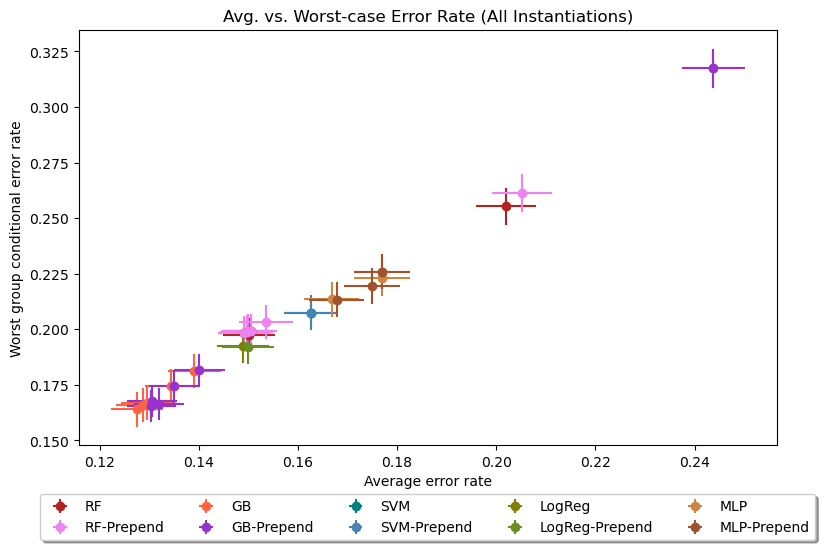

In [28]:
fig, ax = plt.subplots()

# Plot all points for tree-based models
# Random Forests
x_rfs = [all_rfs[num_trees]['erm_test_err'][0] for num_trees in tree_params]
y_rfs = [all_rfs[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_rfs_errs = [std_err(err, num_group_test[0]) for err in x_rfs]
y_rfs_errs = [std_err(err, num_group_test[1]) for err in y_rfs]
ax.errorbar(x_rfs, y_rfs, xerr=x_rfs_errs, yerr=y_rfs_errs, fmt='o', label='RF', color="firebrick")

# Prepend: Random Forests
x_rf_prepend = [rf_prepend[num_trees]['F_test_err'][0] for num_trees in tree_params]
y_rf_prepend = [rf_prepend[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_rf_prepend_errs = [std_err(err, num_group_test[0]) for err in x_rf_prepend]
y_rf_prepend_errs = [std_err(err, num_group_test[1]) for err in y_rf_prepend]
ax.errorbar(x_rf_prepend, y_rf_prepend, xerr=x_rf_prepend_errs, yerr=y_rf_prepend_errs, fmt='o', label='RF-Prepend', color="violet")

# Gradient-Boosted Trees
x_gbs = [all_gbs[num_trees]['erm_test_err'][0] for num_trees in tree_params]
y_gbs = [all_gbs[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_gbs_errs = [std_err(err, num_group_test[0]) for err in x_rfs]
y_gbs_errs = [std_err(err, num_group_test[1]) for err in y_rfs]
ax.errorbar(x_gbs, y_gbs, xerr=x_gbs_errs, yerr=y_gbs_errs, fmt='o', label='GB', color="tomato")

# Prepend: Gradient-Boosted Trees
x_gb_prepend = [gb_prepend[num_trees]['F_test_err'][0] for num_trees in tree_params]
y_gb_prepend = [gb_prepend[num_trees]['worst_gp_err'][0] for num_trees in tree_params]
x_gb_prepend_errs = [std_err(err, num_group_test[0]) for err in x_gb_prepend]
y_gb_prepend_errs = [std_err(err, num_group_test[1]) for err in y_gb_prepend]
ax.errorbar(x_gb_prepend, y_gb_prepend, xerr=x_gb_prepend_errs, yerr=y_gb_prepend_errs, fmt='o', label='GB-Prepend', color="darkorchid")

# SVM
x_svm = [svm['erm_test_err'][0]]
y_svm = [svm['worst_gp_err'][0]]
x_svm_errs = [std_err(err, num_group_test[0]) for err in x_svm]
y_svm_errs = [std_err(err, num_group_test[1]) for err in y_svm]
ax.errorbar(x_svm, y_svm, xerr=x_svm_errs, yerr=y_svm_errs, fmt='o', label="SVM", color="teal")

# Prepend: SVM
x_svm_prepend = [svm_prepend['F_test_err'][0]]
y_svm_prepend = [svm_prepend['worst_gp_err'][0]]
x_svm_prepend_errs = [std_err(err, num_group_test[0]) for err in x_svm_prepend]
y_svm_prepend_errs = [std_err(err, num_group_test[1]) for err in y_svm_prepend]
ax.errorbar(x_svm_prepend, y_svm_prepend, xerr=x_svm_prepend_errs, yerr=y_svm_prepend_errs, fmt='o', label="SVM-Prepend", color="steelblue")

# Logistic Regression
x_logreg = [logreg['erm_test_err'][0]]
y_logreg = [logreg['worst_gp_err'][0]]
x_logreg_errs = [std_err(err, num_group_test[0]) for err in x_logreg]
y_logreg_errs = [std_err(err, num_group_test[1]) for err in y_logreg]
ax.errorbar(x_logreg, y_logreg, xerr=x_logreg_errs, yerr=y_logreg_errs, fmt='o', label="LogReg", color="olive")

# Prepend: Logistic Regression
x_logreg_prepend = [logreg_prepend['F_test_err'][0]]
y_logreg_prepend = [logreg_prepend['worst_gp_err'][0]]
x_logreg_prepend_errs = [std_err(err, num_group_test[0]) for err in x_logreg_prepend]
y_logreg_prepend_errs = [std_err(err, num_group_test[1]) for err in y_logreg_prepend]
ax.errorbar(x_logreg_prepend, y_logreg_prepend, xerr=x_logreg_prepend_errs, yerr=y_logreg_prepend_errs, fmt='o', label="LogReg-Prepend", color="olivedrab")

# MLPs
x_mlps = [all_mlps[hidden_units]['erm_test_err'][0] for hidden_units in hidden_unit_params]
y_mlps = [all_mlps[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params]
x_mlps_errs = [std_err(err, num_group_test[0]) for err in x_mlps]
y_mlps_errs = [std_err(err, num_group_test[1]) for err in y_mlps]
ax.errorbar(x_mlps, y_mlps, xerr=x_mlps_errs, yerr=y_mlps_errs, fmt='o', label='MLP', color="peru")

# Prepend: MLPs
x_mlps_prepend = [mlps_prepend[hidden_units]['F_test_err'][0] for hidden_units in hidden_unit_params]
y_mlps_prepend = [mlps_prepend[hidden_units]['worst_gp_err'][0] for hidden_units in hidden_unit_params]
x_mlps_prepend_errs = [std_err(err, num_group_test[0]) for err in x_mlps_prepend]
y_mlps_prepend_errs = [std_err(err, num_group_test[1]) for err in y_mlps_prepend]
ax.errorbar(x_mlps_prepend, y_mlps_prepend, xerr=x_mlps_prepend_errs, yerr=y_mlps_prepend_errs, fmt='o', label='MLP-Prepend', color="sienna")

ax.set_xlabel('Average error rate')
ax.set_ylabel('Worst group conditional error rate')
fig.set_size_inches(9., 6.)
ax.set_title("Avg. vs. Worst-case Error Rate (All Instantiations)")

# Put legend underneath plot
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

In [47]:
# Best observed average case error, per model class
print("Best Observed Average-Case Errors:")
print('RF:\t\t{0} (+/-{1})'.format(min(x_rfs), std_err(min(x_rfs), num_group_test[0])))
print('RF-Prepend:\t{0} (+/-{1})'.format(min(x_rf_prepend), std_err(min(x_rf_prepend), num_group_test[0])))
print('GB:\t\t{0} (+/-{1})'.format(min(x_gbs), std_err(min(x_gbs), num_group_test[0])))
print('GB-Prepend:\t{0} (+/-{1})'.format(min(x_gb_prepend), std_err(min(x_gb_prepend), num_group_test[0])))
print('SVM:\t\t{0} (+/-{1})'.format(min(x_svm), std_err(min(x_svm), num_group_test[0])))
print('SVM-Prepend:\t{0} (+/-{1})'.format(min(x_svm_prepend), std_err(min(x_svm_prepend), num_group_test[0])))
print('LogReg:\t\t{0} (+/-{1})'.format(min(x_logreg), std_err(min(x_logreg), num_group_test[0])))
print('LogReg-Prepend:\t{0} (+/-{1})'.format(min(x_logreg_prepend), std_err(min(x_logreg_prepend), num_group_test[0])))
print('MLP:\t\t{0} (+/-{1})'.format(min(x_mlps), std_err(min(x_mlps), num_group_test[0])))
print('MLP-Prepend:\t{0} (+/-{1})'.format(min(x_mlps_prepend), std_err(min(x_mlps_prepend), num_group_test[0])))

Best Observed Average-Case Errors:
RF:		0.14914317302377003 (+/-0.005297130171307789)
RF-Prepend:	0.14914317302377003 (+/-0.005297130171307789)
GB:		0.12758430071862908 (+/-0.004961021019770001)
GB-Prepend:	0.1304588170259812 (+/-0.005008325055771677)
SVM:		0.16263128800442234 (+/-0.005487456970751335)
SVM-Prepend:	0.16263128800442234 (+/-0.005487456970751335)
LogReg:		0.14892205638474296 (+/-0.005293889747457745)
LogReg-Prepend:	0.14991708126036485 (+/-0.005308440039837308)
MLP:		0.16683250414593698 (+/-0.00554392320583355)
MLP-Prepend:	0.16782752902155887 (+/-0.005557109889179354)


In [48]:
# Best observed worst-group error, per model class
print("Best Observed Worst-Case Errors:")
print('RF:\t\t{0} (+/-{1})'.format(min(y_rfs), std_err(min(y_rfs), num_group_test[1])))
print('RF-Prepend:\t{0} (+/-{1})'.format(min(y_rf_prepend), std_err(min(y_rf_prepend), num_group_test[1])))
print('GB:\t\t{0} (+/-{1})'.format(min(y_gbs), std_err(min(y_gbs), num_group_test[1])))
print('GB-Prepend:\t{0} (+/-{1})'.format(min(y_gb_prepend), std_err(min(y_gb_prepend), num_group_test[1])))
print('SVM:\t\t{0} (+/-{1})'.format(min(y_svm), std_err(min(y_svm), num_group_test[1])))
print('SVM-Prepend:\t{0} (+/-{1})'.format(min(y_svm_prepend), std_err(min(y_svm_prepend), num_group_test[1])))
print('LogReg:\t\t{0} (+/-{1})'.format(min(y_logreg), std_err(min(y_logreg), num_group_test[1])))
print('LogReg-Prepend:\t{0} (+/-{1})'.format(min(y_logreg_prepend), std_err(min(y_logreg_prepend), num_group_test[1])))
print('MLP:\t\t{0} (+/-{1})'.format(min(y_mlps), std_err(min(y_mlps), num_group_test[1])))
print('MLP-Prepend:\t{0} (+/-{1})'.format(min(y_mlps_prepend), std_err(min(y_mlps_prepend), num_group_test[1])))

Best Observed Worst-Case Errors:
RF:		0.1975263060734724 (+/-0.0076500355508504)
RF-Prepend:	0.19826472217094332 (+/-0.0076607942745930595)
GB:		0.16392837363854532 (+/-0.007113517228493676)
GB-Prepend:	0.1655898098578549 (+/-0.007142367351400359)
SVM:		0.2074949233893299 (+/-0.0077918457103755565)
SVM-Prepend:	0.2074949233893299 (+/-0.0077918457103755565)
LogReg:		0.19254199741554365 (+/-0.0075763196231075644)
LogReg-Prepend:	0.19198818534244047 (+/-0.0075680098284835315)
MLP:		0.213586856193465 (+/-0.007874957587664584)
MLP-Prepend:	0.21321764814472954 (+/-0.007869995050977064)


### Plot 3: Tree Ensemble Comparison
For each group, we compare the effect of ensemble size (`n_estimators`) on the group performance of each tree-based method.
Include two plots: one for Random Forests and one for Gradient-Boosted Trees.

In [50]:
print(num_estimator_params)

[1, 64, 128, 256, 512, 1024]


In [74]:
from sklearn.tree import DecisionTreeClassifier
dec_tree_params = {
    "random_state" : 0,
    "max_features" : "sqrt"
}

# Does n_estimators=1 RF do the same thing as DecisionTree (CART)?
dec_tree = train_and_eval(X_train, group_train, X_test, group_test, y_train, y_test,
                        None, num_groups, DecisionTreeClassifier, "Decision Tree",
                        "N/A", "N/A", dec_tree_params, verbose=True)

print("Random Forests (n_estimators=1)")
print(all_rfs[1]['test_err'])

Decision Tree (N/A=N/A)
group 0 (ALL): 0.20143725815367605 (+/-0.005963965668636379; n=9045)
group 1 (W,M): 0.24386191618977293 (+/-0.008251029260357748; n=5417)
group 2 (W,F): 0.10156580617858654 (+/-0.008788202051466607; n=2363)
group 3 (nW,M): 0.18786127167630057 (+/-0.02099885864504078; n=692)
group 4 (nW,F): 0.09424083769633508 (+/-0.017260907440733962; n=573)
PREPEND group 0 (ALL): 0.20143725815367605 (+/-0.005963965668636379; n=9045)
PREPEND group 1 (W,M): 0.25512276167620457 (+/-0.00837630602042881; n=5417)
PREPEND group 2 (W,F): 0.10325856961489632 (+/-0.00885278275565467; n=2363)
PREPEND group 3 (nW,M): 0.2023121387283237 (+/-0.02159680031772899; n=692)
PREPEND group 4 (nW,F): 0.09773123909249563 (+/-0.017543746766401806; n=573)
Random Forests (n_estimators=1)
{0: 0.2019900497512438, 1: 0.2613992985047074, 2: 0.11045281421921287, 3: 0.18208092485549132, 4: 0.1099476439790576}


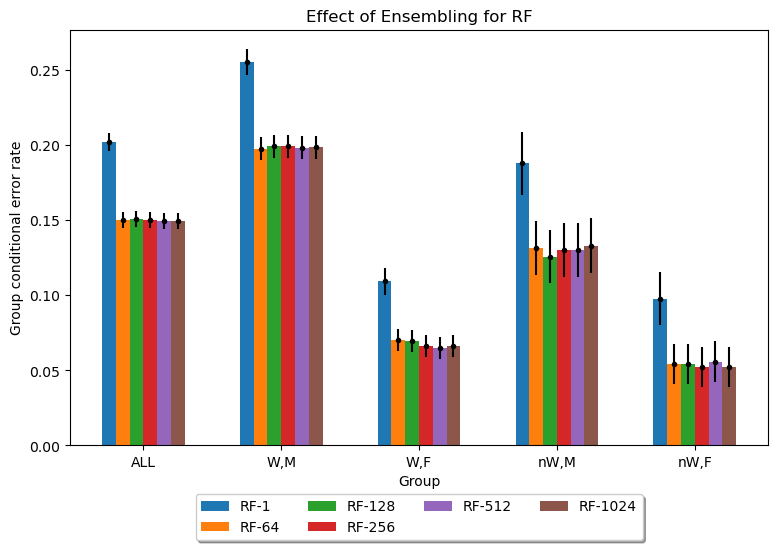

In [65]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_rfs[1]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_rfs[64]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_rfs[128]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_rfs[256]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_rfs[512]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_rfs[1024]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_rfs[1]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_rfs[64]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[64]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_rfs[128]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[128]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_rfs[256]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[256]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_rfs[512]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[512]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_rfs[1024]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1024]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

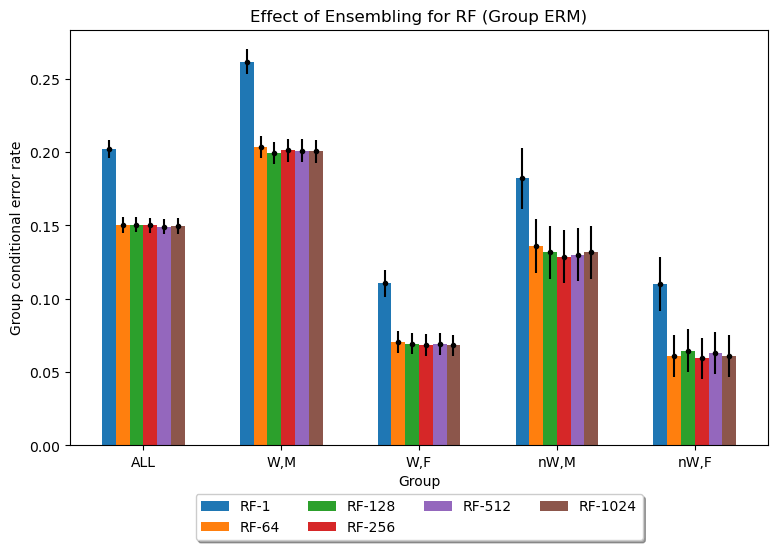

In [66]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_rfs[1]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_rfs[64]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_rfs[128]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_rfs[256]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_rfs[512]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_rfs[1024]['test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_rfs[1]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_rfs[64]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[64]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_rfs[128]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[128]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_rfs[256]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[256]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_rfs[512]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[512]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_rfs[1024]['test_err'][g] for g in range(num_groups)], [std_err(all_rfs[1024]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF (Group ERM)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

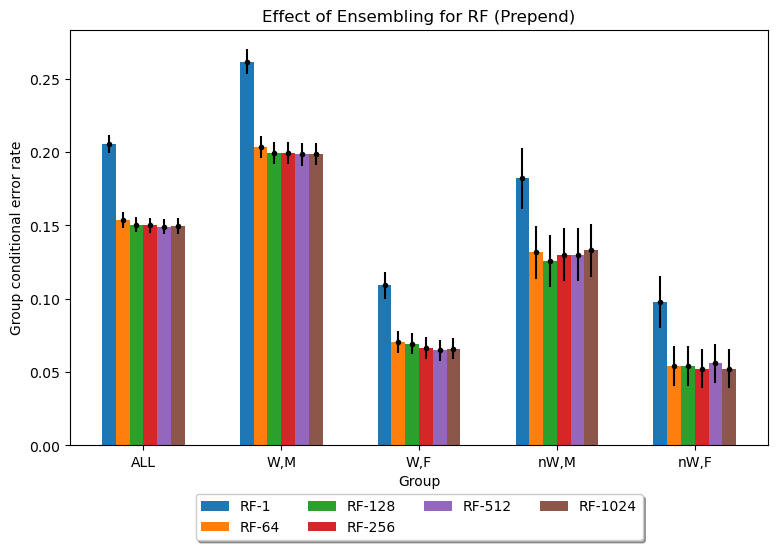

In [67]:
# Ensemble Comparison: Random Forests
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [rf_prepend[1]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [rf_prepend[64]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [rf_prepend[128]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [rf_prepend[256]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [rf_prepend[512]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [rf_prepend[1024]['F_test_err'][g] for g in range(num_groups)], bar_width, label='RF-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [rf_prepend[1]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[1]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [rf_prepend[64]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[64]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [rf_prepend[128]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[128]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [rf_prepend[256]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[256]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [rf_prepend[512]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[512]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [rf_prepend[1024]['F_test_err'][g] for g in range(num_groups)], [std_err(rf_prepend[1024]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for RF (Prepend)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

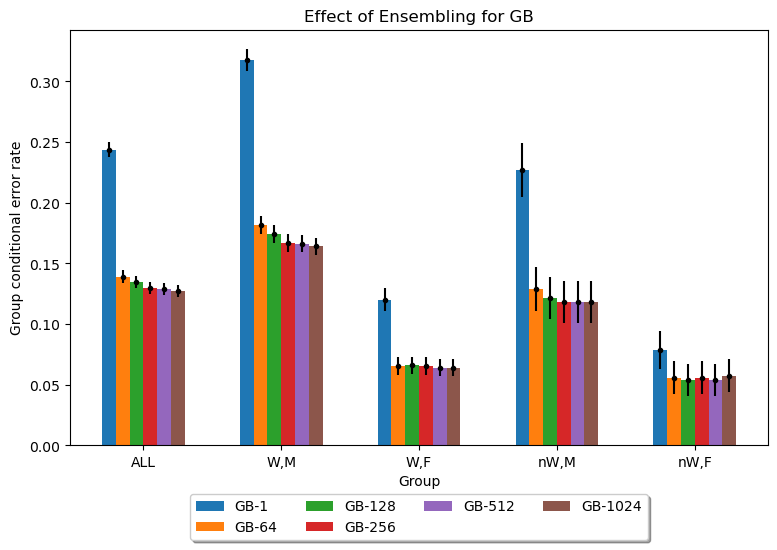

In [76]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_gbs[1]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_gbs[64]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_gbs[128]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_gbs[256]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_gbs[512]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_gbs[1024]['erm_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_gbs[1]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_gbs[64]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[64]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_gbs[128]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[128]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_gbs[256]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[256]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_gbs[512]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[512]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_gbs[1024]['erm_test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1024]['erm_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

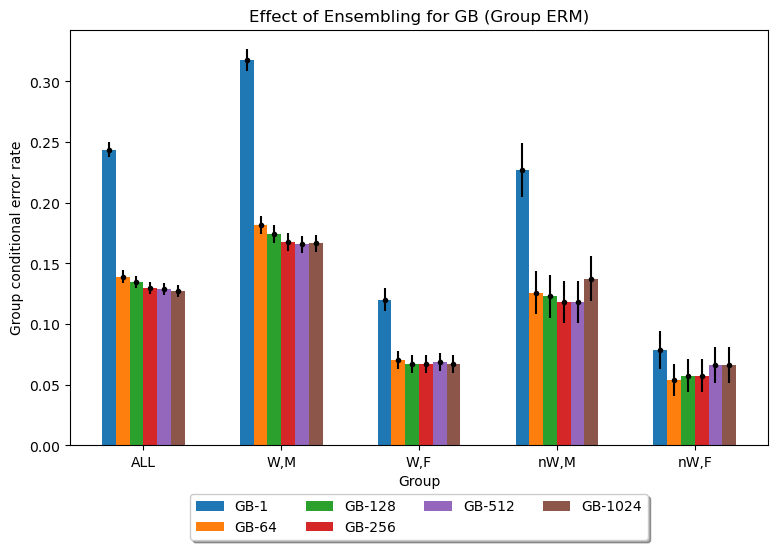

In [77]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [all_gbs[1]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [all_gbs[64]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [all_gbs[128]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [all_gbs[256]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [all_gbs[512]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [all_gbs[1024]['test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [all_gbs[1]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [all_gbs[64]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[64]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [all_gbs[128]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[128]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [all_gbs[256]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[256]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [all_gbs[512]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[512]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [all_gbs[1024]['test_err'][g] for g in range(num_groups)], [std_err(all_gbs[1024]['test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB (Group ERM)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()

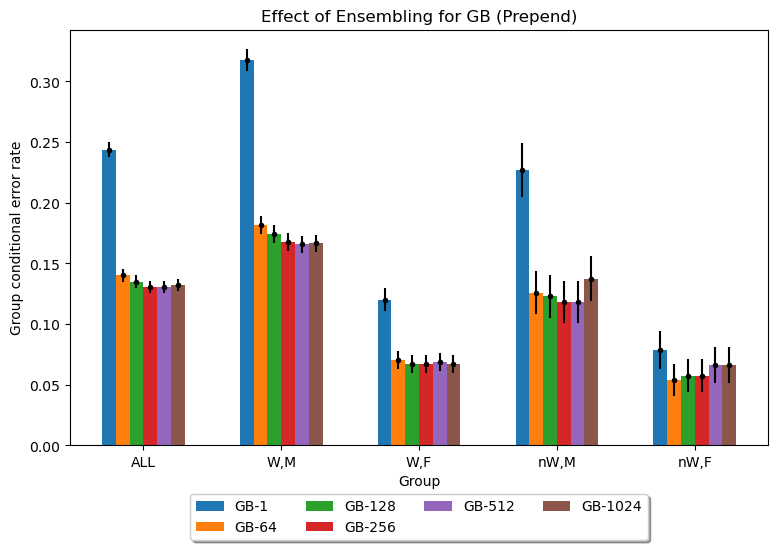

In [78]:
# Ensemble Comparison: Gradient-Boosted Trees
plot_group_labels = group_names
plot_x = np.arange(num_groups)
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 2.5*bar_width, [gb_prepend[1]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1')
plot_rects2 = ax.bar(plot_x - 1.5*bar_width, [gb_prepend[64]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-64')
plot_rects3 = ax.bar(plot_x - 0.5*bar_width, [gb_prepend[128]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-128')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [gb_prepend[256]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-256')
plot_rects5 = ax.bar(plot_x + 1.5*bar_width, [gb_prepend[512]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-512')
plot_rects6 = ax.bar(plot_x + 2.5*bar_width, [gb_prepend[1024]['F_test_err'][g] for g in range(num_groups)], bar_width, label='GB-1024')

plot_err1 = ax.errorbar(plot_x - 2.5*bar_width, [gb_prepend[1]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[1]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err2 = ax.errorbar(plot_x - 1.5*bar_width, [gb_prepend[64]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[64]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err3 = ax.errorbar(plot_x - 0.5*bar_width, [gb_prepend[128]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[128]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [gb_prepend[256]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[256]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err5 = ax.errorbar(plot_x + 1.5*bar_width, [gb_prepend[512]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[512]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")
plot_err6 = ax.errorbar(plot_x + 2.5*bar_width, [gb_prepend[1024]['F_test_err'][g] for g in range(num_groups)], [std_err(gb_prepend[1024]['F_test_err'][g], num_group_test[g]) for g in range(num_groups)], fmt='.', color="Black")

ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Effect of Ensembling for GB (Prepend)")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

plt.show()